In [ ]:
"""
TODO: 

Implement linear system class for managing state transition.
Tune process and measurement covariance.
"""

In [76]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import multi_dot
from numpy.random import multivariate_normal
np.random.seed(21)

In [62]:
# Notation

# A: n x n, state transition
# H: m x n, measurement viewpoint
# K: n x m, kalman gain
# P: n x n, error covariance
# R: n x n, process covariance

# x: n x 1, state
# w: n x 1, process noise
# v: n x 1, measurement noise

In [130]:
class Kalman:
    
    def __init__(self, n, m, A, H, R, Q):
        self.n = n
        self.m = m
        
        self.A = np.random.rand(n, n)
        self.H = np.random.rand(m, n)
        
        self.K = np.zeros((n, m))
        self.P = np.eye(n)
        self.R = np.eye(m)
        self.Q = np.eye(n)
        
        self.x = [-1, 2]
        self.x_est = np.zeros(n)
        
    def forward(self):
        state_transition = self.A @ self.x
        process_noise = multivariate_normal(np.zeros(self.n), self.Q)
        self.x = state_transition + process_noise
        
    def measurement(self):
        measurement_noise = multivariate_normal(np.zeros(m), self.R)
        self.z = self.H @ self.x + measurement_noise
    
    def update_kalman_gain(self):
        prod = multi_dot((self.H, self.P, self.H.T))
        inv = np.linalg.pinv(prod + self.R)
        self.K = multi_dot((self.P, self.H.T, inv))

    def update_estimate(self):
        innovation = self.z - self.H @ self.x_est
        self.x_est = self.x_est + self.K @ innovation
    
    def update_covariance(self):
        I = np.eye(self.n)
        self.P = (I - self.K @ self.H) @ self.P
        
    def project_ahead(self):
        self.x_est = self.A @ self.x_est
        self.P = multi_dot((self.A, self.P, self.A.T)) + self.Q
        
    def loop(self):
        self.update_kalman_gain()
        self.update_estimate()
        self.update_covariance()
        self.project_ahead()

In [131]:
n = 2
m = 1

A = np.array([
    [0.9, 0.2], 
    [-0.3, 1.1]
])

H = 1.3 * np.eye(m)
R = np.eye(m)
Q = np.eye(n)

kalman = Kalman(n, m, A, H, R, Q)

In [132]:
num_iters = 100

x = []
x_est = []
 
for i in range(num_iters):
    x.append(kalman.x)
    x_est.append(kalman.x_est)
    
    kalman.forward()
    kalman.measurement()
    kalman.loop()

x = np.array(x)
x_est = np.array(x_est)

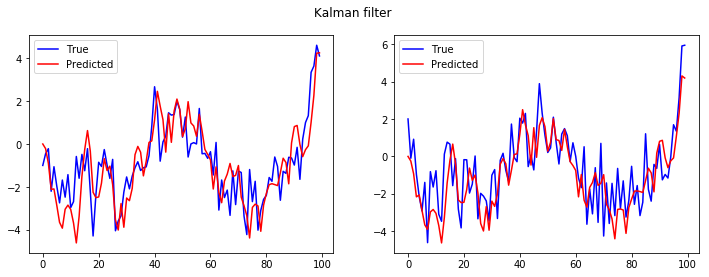

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for a, xi, xi_est in zip(ax, x.T, x_est.T):
    a.plot(xi, 'blue')
    a.plot(xi_est, 'red')
    a.legend(['True', 'Predicted'])
    
fig.suptitle('Kalman filter')
plt.show()